# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# Downgrade to the prior release 
!pip install cftime==1.0.4.2
# Learned this from Birk
# Website: https://github.com/pvlib/pvlib-python/issues/895

# Try to save Excel
!pip install openpyxl

In [3]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
from matplotlib import pyplot
%matplotlib inline

# Specify Location (Denver, CO)
latitude, longitude, tz = 39.7, -105.2, 'America/Denver'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=2)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [4]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [5]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

### Instantiate a GFS model object and get the forecast data from Unidata

In [6]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_low_cloud_Mixed_intervals_Average  \
2020-04-19 06:00:00-06:00                                               16.0     
2020-04-19 09:00:00-06:00                                               35.0     
2020-04-19 12:00:00-06:00                                               50.0     
2020-04-19 15:00:00-06:00                                                0.0     
2020-04-19 18:00:00-06:00                                                0.0     

                           Temperature_surface  \
2020-04-19 06:00:00-06:00           273.802826   
2020-04-19 09:00:00-06:00           271.768555   
2020-04-19 12:00:00-06:00           270.168579   
2020-04-19 15:00:00-06:00           281.399994   
2020-04-19 18:00:00-06:00           292.299988   

                           Total_cloud_cover_convective_cloud  \
2020-04-19 06:00:00-06:00                                 0.0   
2020-04-19 09:00:00-06:00                                 0.0   
2020-04-19 

### Process Data with pvlib

In [7]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi        dni  \
2020-04-19 06:00:00-06:00   0.652832    3.293248    0.000000   0.000000   
2020-04-19 09:00:00-06:00  -1.381439    3.272084  158.364392   1.706660   
2020-04-19 12:00:00-06:00  -2.981415    1.495144  299.827624  16.407711   
2020-04-19 15:00:00-06:00   8.250000    1.251417  449.177885  99.896446   
2020-04-19 18:00:00-06:00  19.149994    1.134768  142.451870  55.614143   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-19 06:00:00-06:00    0.000000          86.0        16.0        69.0   
2020-04-19 09:00:00-06:00  157.503214         100.0        35.0        89.0   
2020-04-19 12:00:00-06:00  285.783767         100.0        50.0        93.0   
2020-04-19 15:00:00-06:00  371.220084          64.0         0.0        25.0   
2020-04-19 18:00:00-06:00  124.508778          66.0         0.0        12.0   

                           high_clouds  
2020-04-19 06:00:00-06:00        

### GFS'S Class

In [8]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi        dni  \
2020-04-19 06:00:00-06:00   0.652832    3.293248    0.000000   0.000000   
2020-04-19 09:00:00-06:00  -1.381439    3.272084  158.364392   1.706660   
2020-04-19 12:00:00-06:00  -2.981415    1.495144  299.827624  16.407711   
2020-04-19 15:00:00-06:00   8.250000    1.251417  449.177885  99.896446   
2020-04-19 18:00:00-06:00  19.149994    1.134768  142.451870  55.614143   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-19 06:00:00-06:00    0.000000          86.0        16.0        69.0   
2020-04-19 09:00:00-06:00  157.503214         100.0        35.0        89.0   
2020-04-19 12:00:00-06:00  285.783767         100.0        50.0        93.0   
2020-04-19 15:00:00-06:00  371.220084          64.0         0.0        25.0   
2020-04-19 18:00:00-06:00  124.508778          66.0         0.0        12.0   

                           high_clouds  
2020-04-19 06:00:00-06:00        

## Cloud Cover & Radiation

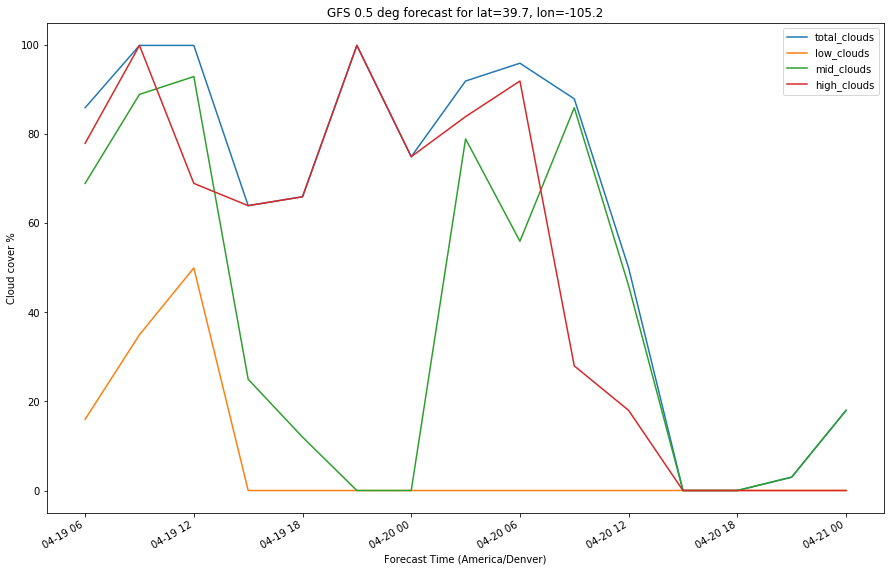

In [9]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

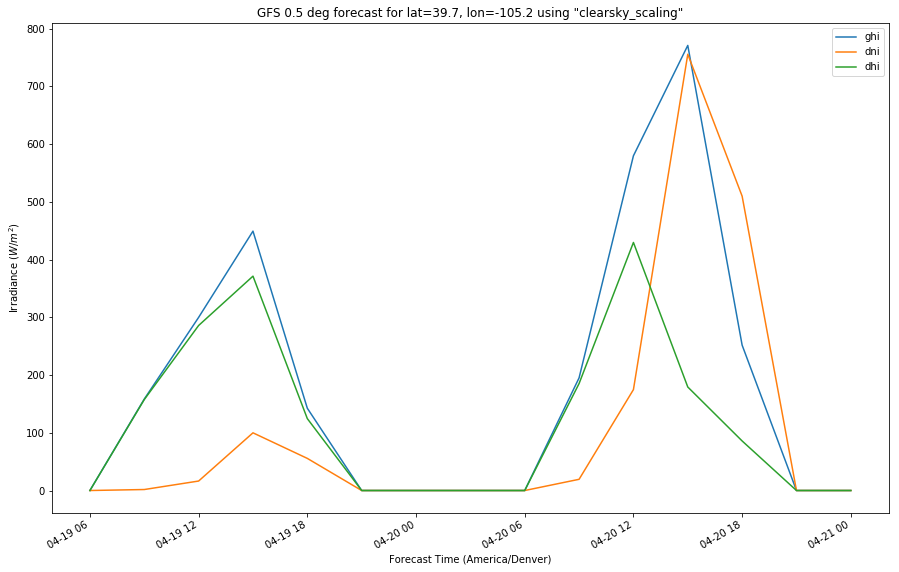

In [10]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

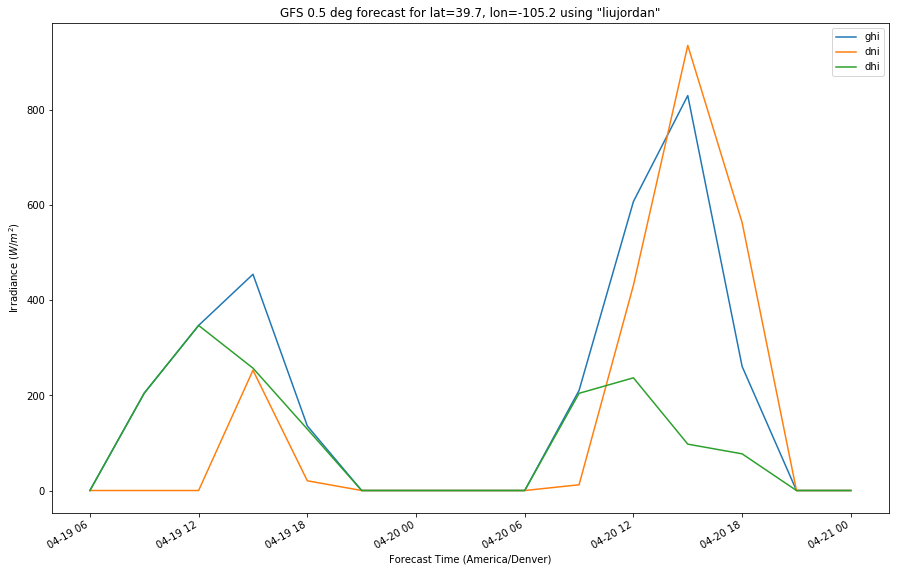

In [11]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

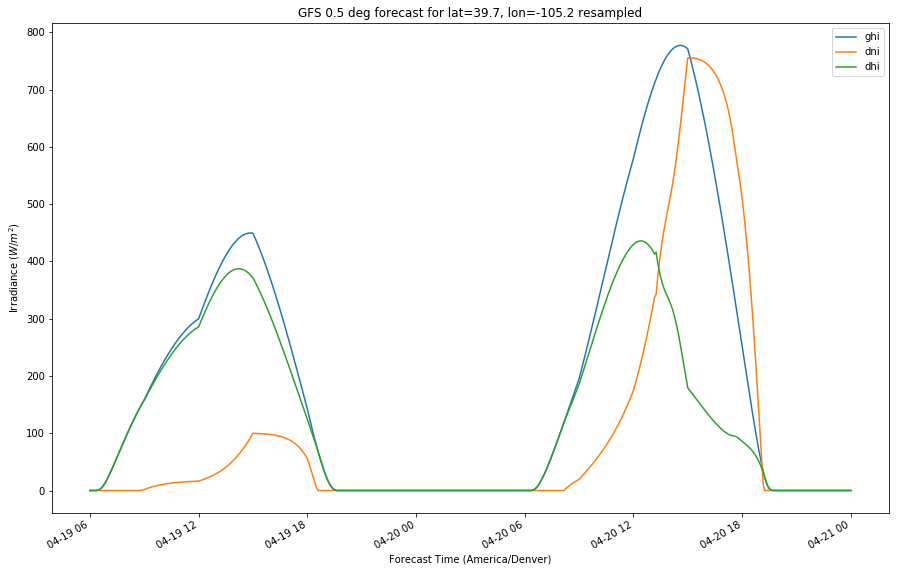

In [12]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

In [13]:
resampled_irrads

,ghi,dni,dhi
2020-04-19 06:00:00-06:00,0.000000,0.0,0.000000
2020-04-19 06:05:00-06:00,0.000000,0.0,0.000000
2020-04-19 06:10:00-06:00,0.000000,0.0,0.000000
2020-04-19 06:15:00-06:00,0.000000,0.0,0.000000
2020-04-19 06:20:00-06:00,0.025401,0.0,0.025401
2020-04-19 06:25:00-06:00,0.297539,0.0,0.297539
2020-04-19 06:30:00-06:00,1.148332,0.0,1.148332
2020-04-19 06:35:00-06:00,2.839222,0.0,2.839222
2020-04-19 06:40:00-06:00,5.438532,0.0,5.438532
2020-04-19 06:45:00-06:00,8.872903,0.0,8.872903


In [14]:
resampled_irrads.to_csv('5 min Irradiance.csv', encoding='utf-8')

## Weather Models
### GFS

In [15]:
# The Global Forecast System is the US model that provides forecast for the entire globe
# It is updated every six hours

### HRRR

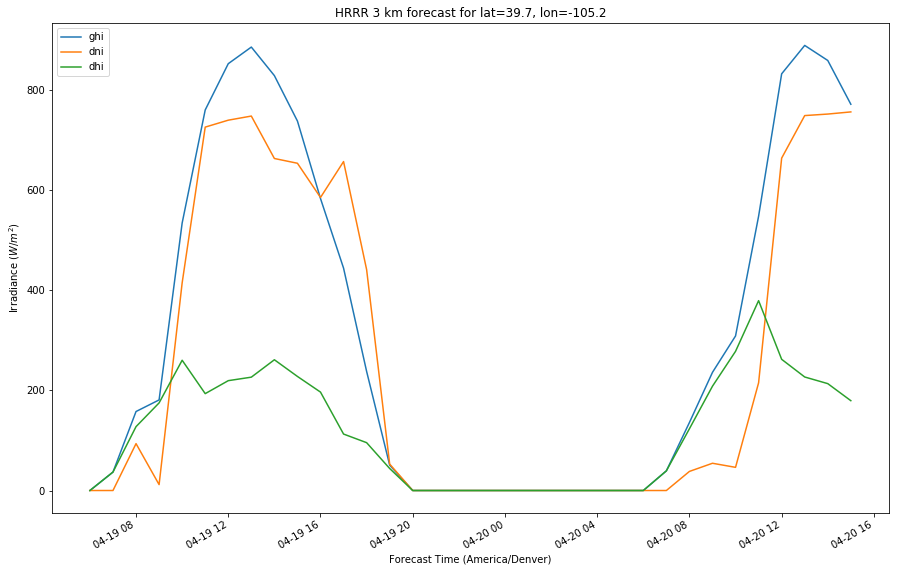

In [16]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

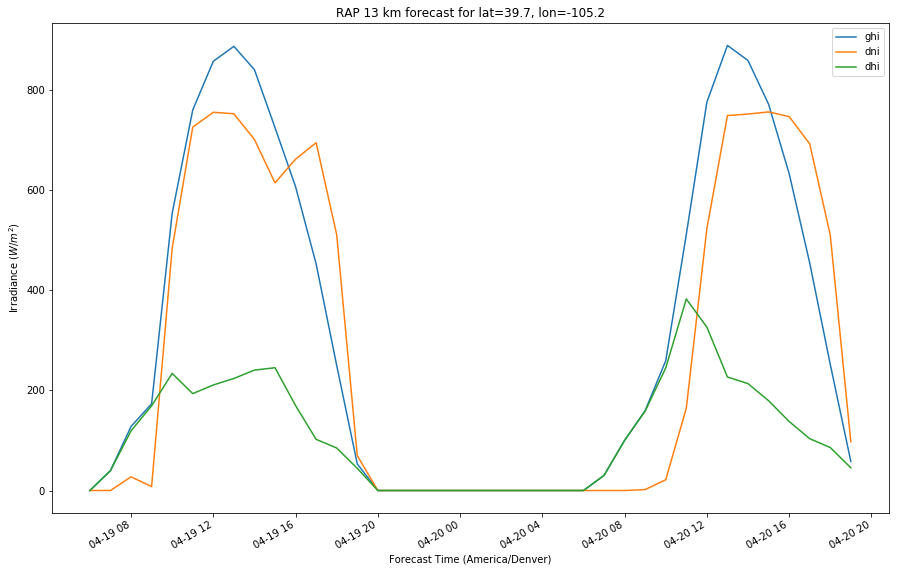

In [17]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

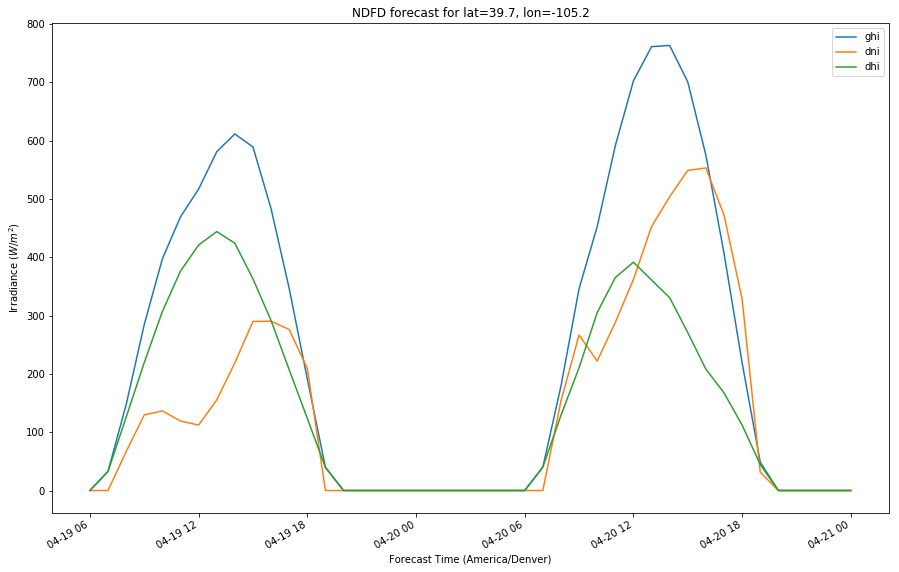

In [18]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

## PV Power Forecast

In [19]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)



ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

### ModelChain Attributes

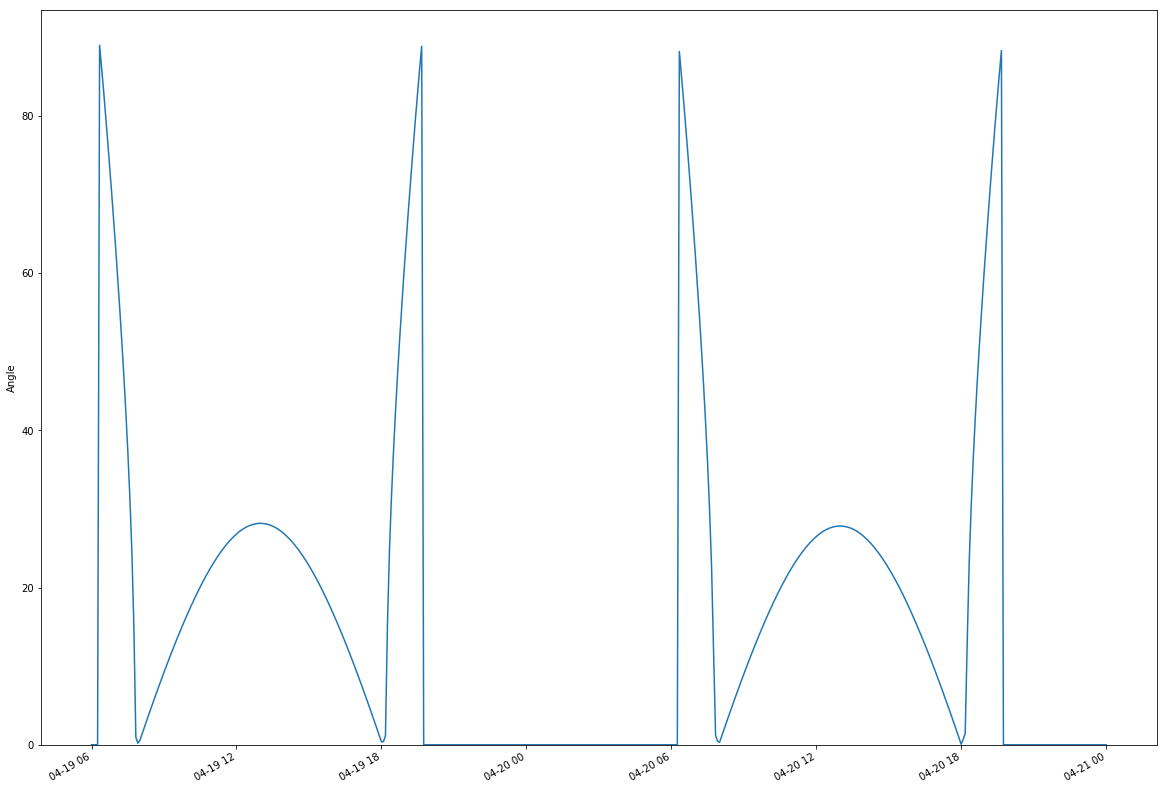

In [20]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

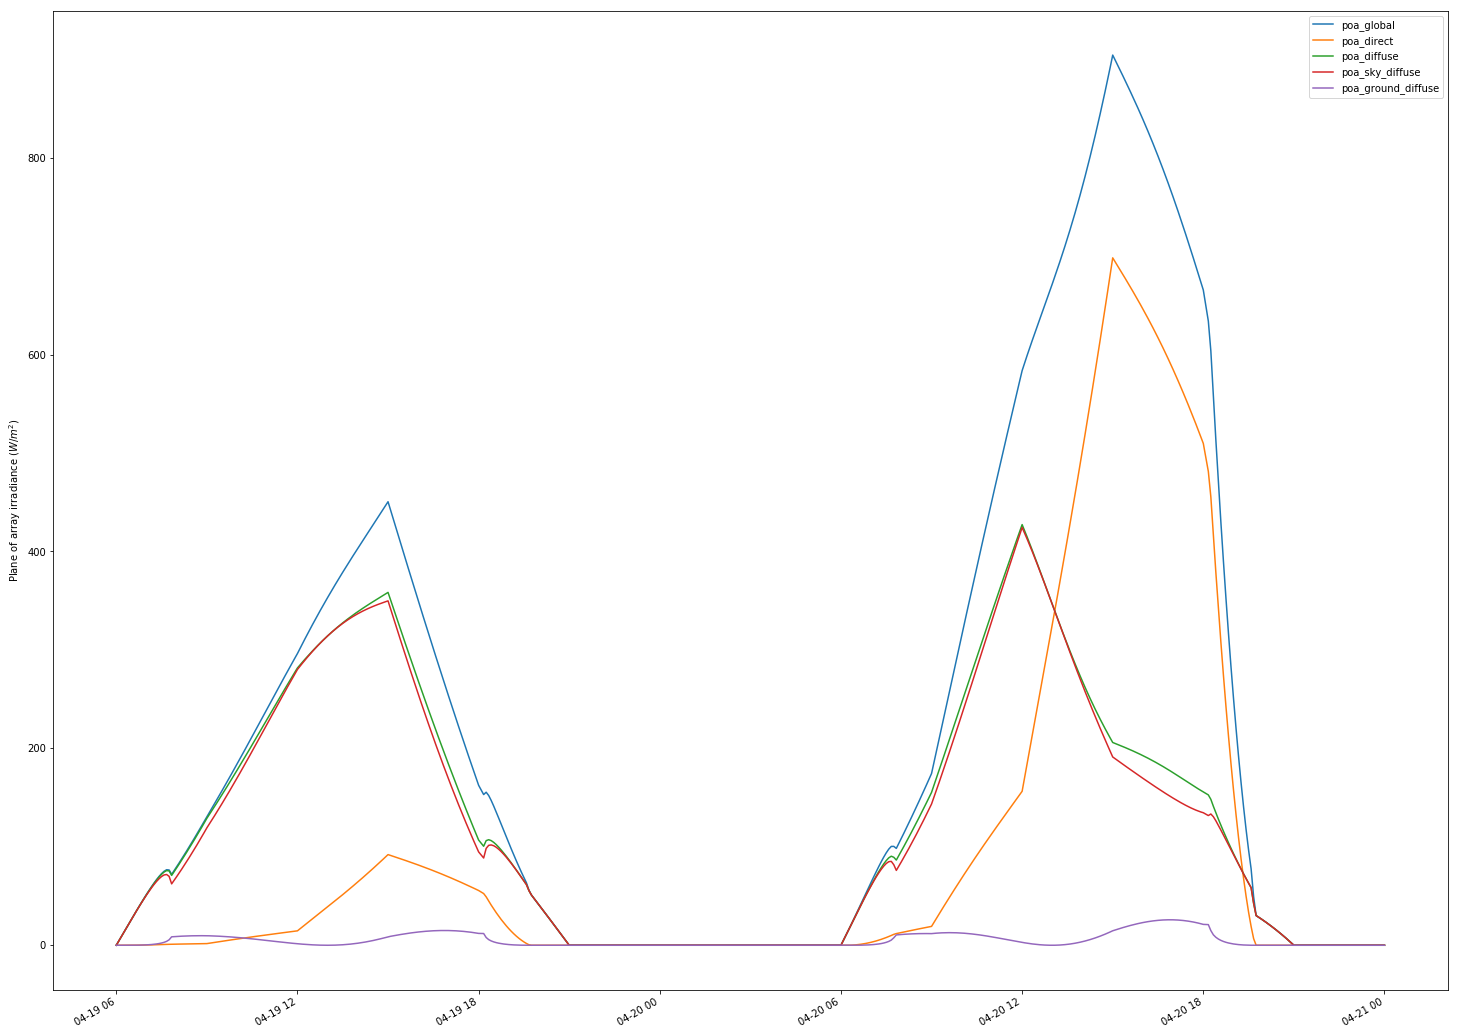

In [21]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

In [22]:
mc.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-04-19 06:00:00-06:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-04-19 06:05:00-06:00,4.374936,0.000000,4.374936,4.374936,0.000000
2020-04-19 06:10:00-06:00,8.749565,0.000000,8.749565,8.749565,0.000000
2020-04-19 06:15:00-06:00,13.123888,0.000000,13.123888,13.123888,0.000000
2020-04-19 06:20:00-06:00,17.503296,0.003434,17.499862,17.499664,0.000197
2020-04-19 06:25:00-06:00,21.890875,0.015990,21.874884,21.871478,0.003407
2020-04-19 06:30:00-06:00,26.260294,0.033940,26.226354,26.213598,0.012756
2020-04-19 06:35:00-06:00,30.608673,0.057396,30.551276,30.519997,0.031279
2020-04-19 06:40:00-06:00,34.926395,0.086382,34.840013,34.777796,0.062217
2020-04-19 06:45:00-06:00,39.202987,0.120897,39.082090,38.973001,0.109089


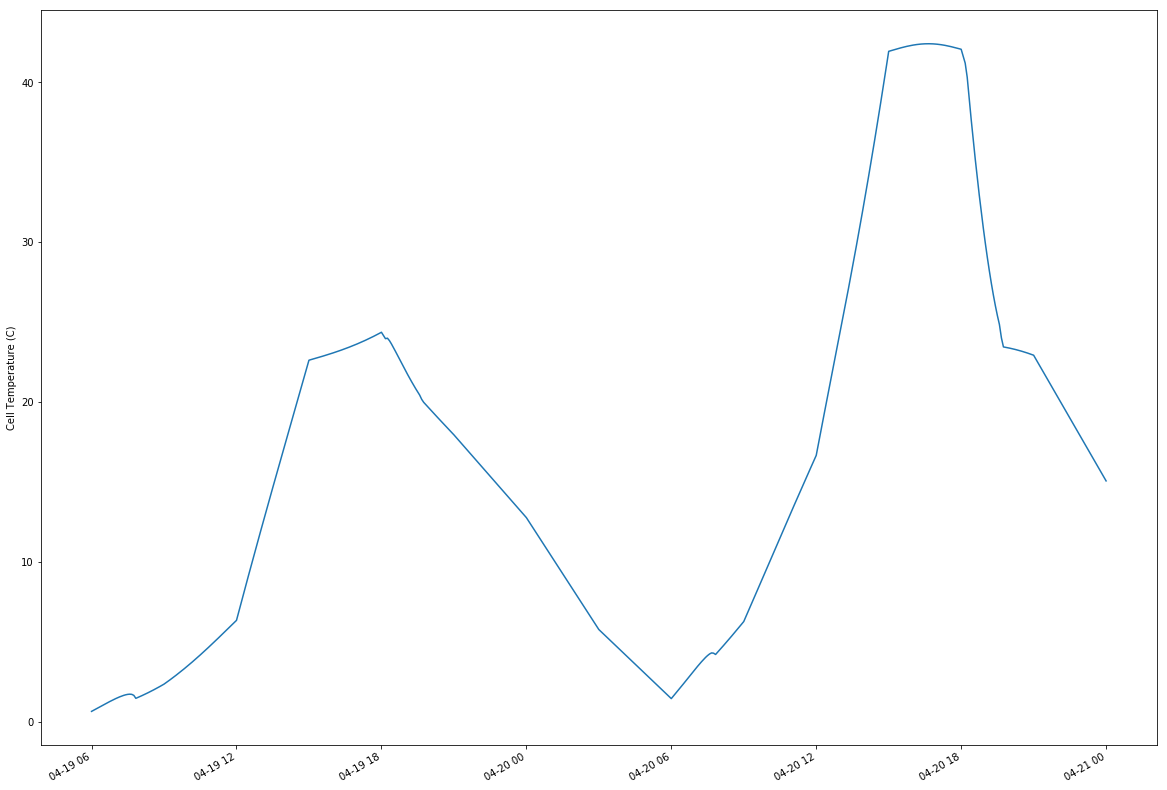

In [23]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

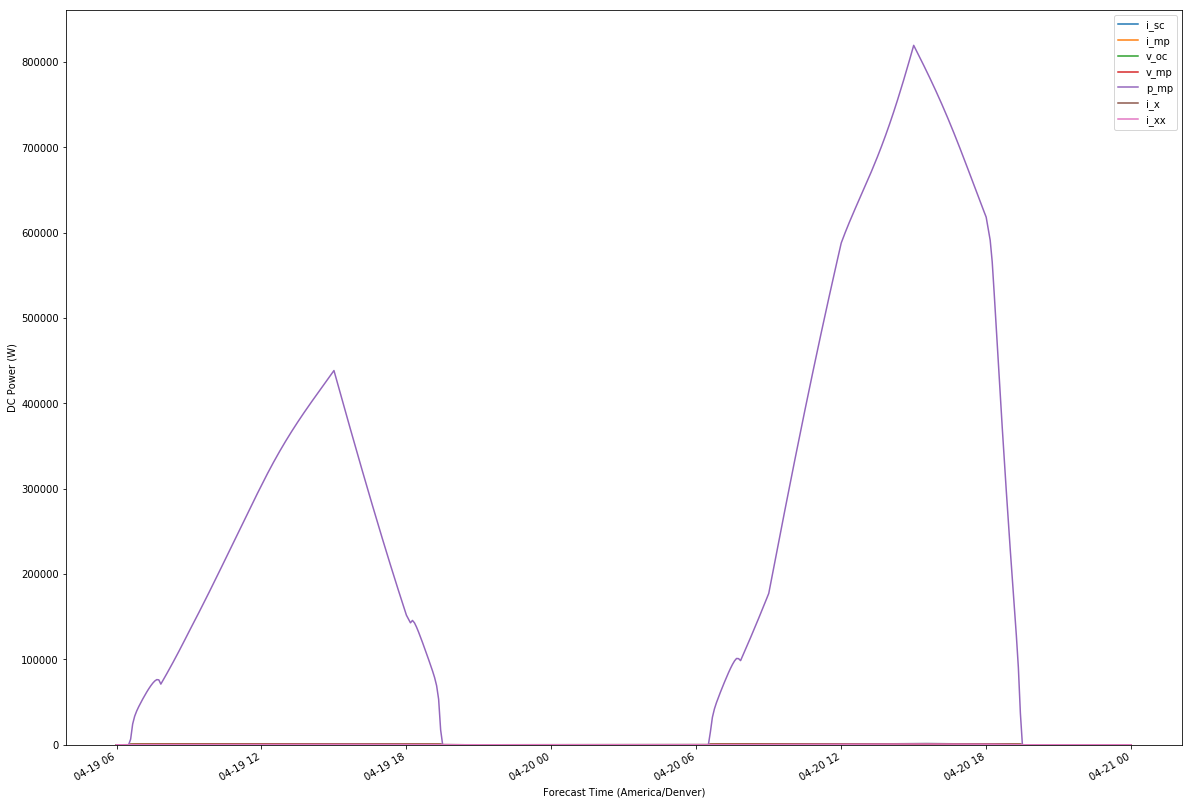

In [24]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

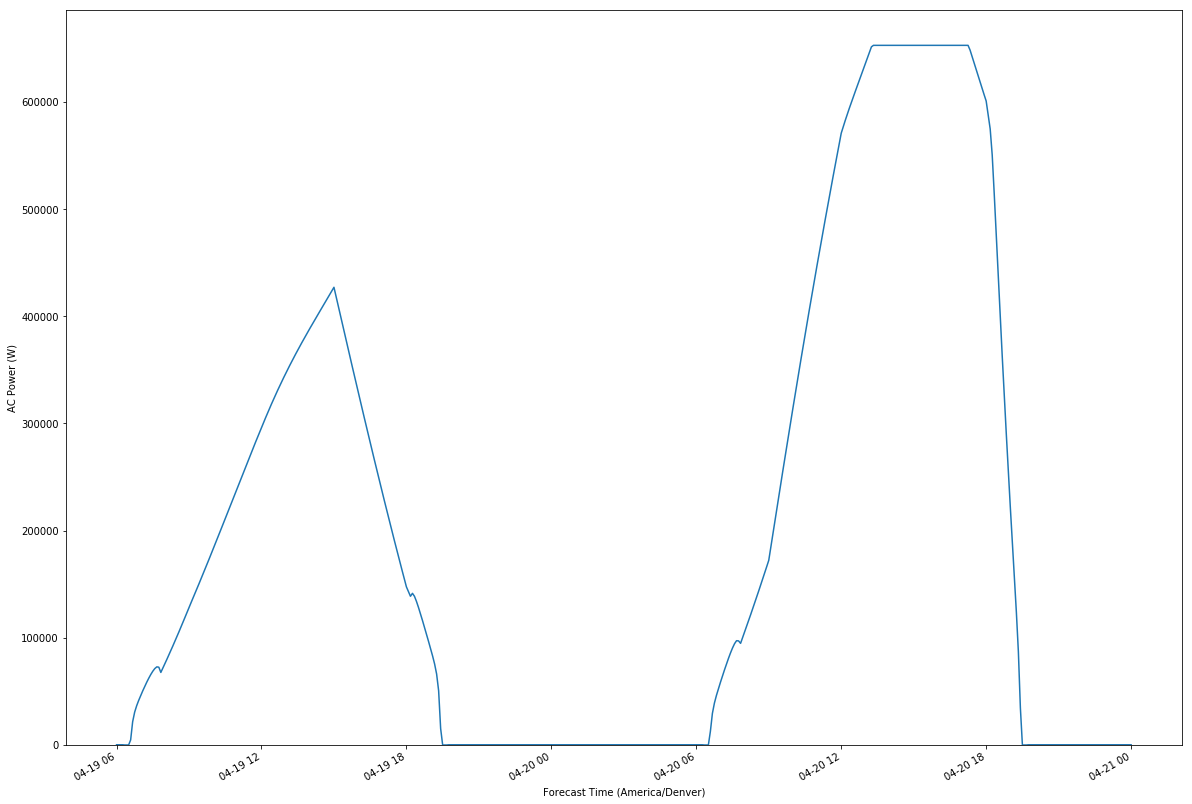

In [25]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [26]:
mc.ac.fillna(0)

2020-04-19 06:00:00-06:00        0.000000
2020-04-19 06:05:00-06:00        0.000000
2020-04-19 06:10:00-06:00        0.000000
2020-04-19 06:15:00-06:00        0.000000
2020-04-19 06:20:00-06:00     -195.900000
2020-04-19 06:25:00-06:00     -195.900000
2020-04-19 06:30:00-06:00     -195.900000
2020-04-19 06:35:00-06:00     4514.468954
2020-04-19 06:40:00-06:00    21532.407038
2020-04-19 06:45:00-06:00    30487.045981
2020-04-19 06:50:00-06:00    36480.202083
2020-04-19 06:55:00-06:00    41428.011618
2020-04-19 07:00:00-06:00    45964.086667
2020-04-19 07:05:00-06:00    50284.959560
2020-04-19 07:10:00-06:00    54434.490846
2020-04-19 07:15:00-06:00    58398.952495
2020-04-19 07:20:00-06:00    62136.826511
2020-04-19 07:25:00-06:00    65583.112009
2020-04-19 07:30:00-06:00    68638.205195
2020-04-19 07:35:00-06:00    71133.966387
2020-04-19 07:40:00-06:00    72730.296945
2020-04-19 07:45:00-06:00    72416.091680
2020-04-19 07:50:00-06:00    67535.841379
2020-04-19 07:55:00-06:00    71563

In [27]:
mc.ac.describe()

count       322.000000
mean     321666.910534
std      215649.225441
min        -195.900000
25%      132916.104877
50%      291260.550011
75%      519311.535819
max      653000.000000
dtype: float64

In [28]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')

# NREL Data
## Monday & Tuesday
### Irradiance & Temperature

In [6]:
# Read Irradiance & Temperature data

nrel_df = pd.read_csv('Apr 20 21 Entire Day.txt')
print("Keys of nrel_df: \n{}".format(nrel_df.keys()))

Keys of nrel_df: 
Index(['DATE (MM/DD/YYYY)', 'MST', 'Global Horizontal [W/m^2]',
       'Direct Normal [W/m^2]', 'Diffuse Horizontal [W/m^2]'],
      dtype='object')


In [7]:
# Columns Rename - Remove [ ]
nrel_df = nrel_df.rename(columns = {'Global Horizontal [W/m^2]': 'GHI', 'Direct Normal [W/m^2]': 'DNI', 'DATE (MM/DD/YYYY)': 'DATE', 'Diffuse Horizontal [W/m^2]': 'DHI'})

In [8]:
nrel_df.describe()

,GHI,DNI,DHI
count,2880.000000,2880.000000,2880.000000
mean,258.551138,280.078716,65.154737
std,341.050304,383.732866,78.028731
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,44.937600,0.000000,38.123150
75%,528.715750,753.676500,108.931750
max,1031.400000,950.568000,305.001000


In [9]:
# Columns that contain NaN values (True = Nan value)
nrel_df.isnull().any()

DATE    False
MST     False
GHI     False
DNI     False
DHI     False
dtype: bool

In [10]:
nrel_df['Time'] = pd.to_datetime(nrel_df['MST']) 

In [11]:
nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

0        0.000000
1        0.016667
2        0.033333
3        0.050000
4        0.066667
5        0.083333
6        0.100000
7        0.116667
8        0.133333
9        0.150000
10       0.166667
11       0.183333
12       0.200000
13       0.216667
14       0.233333
15       0.250000
16       0.266667
17       0.283333
18       0.300000
19       0.316667
20       0.333333
21       0.350000
22       0.366667
23       0.383333
24       0.400000
25       0.416667
26       0.433333
27       0.450000
28       0.466667
29       0.483333
          ...    
2850    23.500000
2851    23.516667
2852    23.533333
2853    23.550000
2854    23.566667
2855    23.583333
2856    23.600000
2857    23.616667
2858    23.633333
2859    23.650000
2860    23.666667
2861    23.683333
2862    23.700000
2863    23.716667
2864    23.733333
2865    23.750000
2866    23.766667
2867    23.783333
2868    23.800000
2869    23.816667
2870    23.833333
2871    23.850000
2872    23.866667
2873    23.883333
2874    23

In [12]:
nrel_df['Time Float'] = nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

In [13]:
nrel_df.rename(columns={'Time Float':'Hours', 'MST':'Time', 'Time':'MST'}, inplace=True)

In [14]:
nrel_df.head(10)

,DATE,Time,GHI,DNI,DHI,MST,Hours
0,4/20/2020,00:00,0.000000,0.0,0.000000,2020-05-01 00:00:00,0.000000
1,4/20/2020,00:01,0.074091,0.0,0.074091,2020-05-01 00:01:00,0.016667
2,4/20/2020,00:02,0.037046,0.0,0.037046,2020-05-01 00:02:00,0.033333
3,4/20/2020,00:03,0.000000,0.0,0.000000,2020-05-01 00:03:00,0.050000
4,4/20/2020,00:04,0.037045,0.0,0.037045,2020-05-01 00:04:00,0.066667
5,4/20/2020,00:05,0.037045,0.0,0.037045,2020-05-01 00:05:00,0.083333
6,4/20/2020,00:06,0.000000,0.0,0.000000,2020-05-01 00:06:00,0.100000
7,4/20/2020,00:07,0.037046,0.0,0.037046,2020-05-01 00:07:00,0.116667
8,4/20/2020,00:08,0.000000,0.0,0.000000,2020-05-01 00:08:00,0.133333
9,4/20/2020,00:09,0.000000,0.0,0.000000,2020-05-01 00:09:00,0.150000


In [15]:
nrel_df.tail(10)

,DATE,Time,GHI,DNI,DHI,MST,Hours
2870,4/21/2020,23:50,0.0,0.0,0.0,2020-05-01 23:50:00,23.833333
2871,4/21/2020,23:51,0.0,0.0,0.0,2020-05-01 23:51:00,23.850000
2872,4/21/2020,23:52,0.0,0.0,0.0,2020-05-01 23:52:00,23.866667
2873,4/21/2020,23:53,0.0,0.0,0.0,2020-05-01 23:53:00,23.883333
2874,4/21/2020,23:54,0.0,0.0,0.0,2020-05-01 23:54:00,23.900000
2875,4/21/2020,23:55,0.0,0.0,0.0,2020-05-01 23:55:00,23.916667
2876,4/21/2020,23:56,0.0,0.0,0.0,2020-05-01 23:56:00,23.933333
2877,4/21/2020,23:57,0.0,0.0,0.0,2020-05-01 23:57:00,23.950000
2878,4/21/2020,23:58,0.0,0.0,0.0,2020-05-01 23:58:00,23.966667
2879,4/21/2020,23:59,0.0,0.0,0.0,2020-05-01 23:59:00,23.983333


In [16]:
nrel_df = nrel_df[["DATE","MST","Time","Hours","GHI","DHI","DNI"]]

In [17]:
nrel_df.head()

,DATE,MST,Time,Hours,GHI,DHI,DNI
0,4/20/2020,2020-05-01 00:00:00,00:00,0.000000,0.000000,0.000000,0.0
1,4/20/2020,2020-05-01 00:01:00,00:01,0.016667,0.074091,0.074091,0.0
2,4/20/2020,2020-05-01 00:02:00,00:02,0.033333,0.037046,0.037046,0.0
3,4/20/2020,2020-05-01 00:03:00,00:03,0.050000,0.000000,0.000000,0.0
4,4/20/2020,2020-05-01 00:04:00,00:04,0.066667,0.037045,0.037045,0.0


In [18]:
nrel_df.tail()

,DATE,MST,Time,Hours,GHI,DHI,DNI
2875,4/21/2020,2020-05-01 23:55:00,23:55,23.916667,0.0,0.0,0.0
2876,4/21/2020,2020-05-01 23:56:00,23:56,23.933333,0.0,0.0,0.0
2877,4/21/2020,2020-05-01 23:57:00,23:57,23.950000,0.0,0.0,0.0
2878,4/21/2020,2020-05-01 23:58:00,23:58,23.966667,0.0,0.0,0.0
2879,4/21/2020,2020-05-01 23:59:00,23:59,23.983333,0.0,0.0,0.0


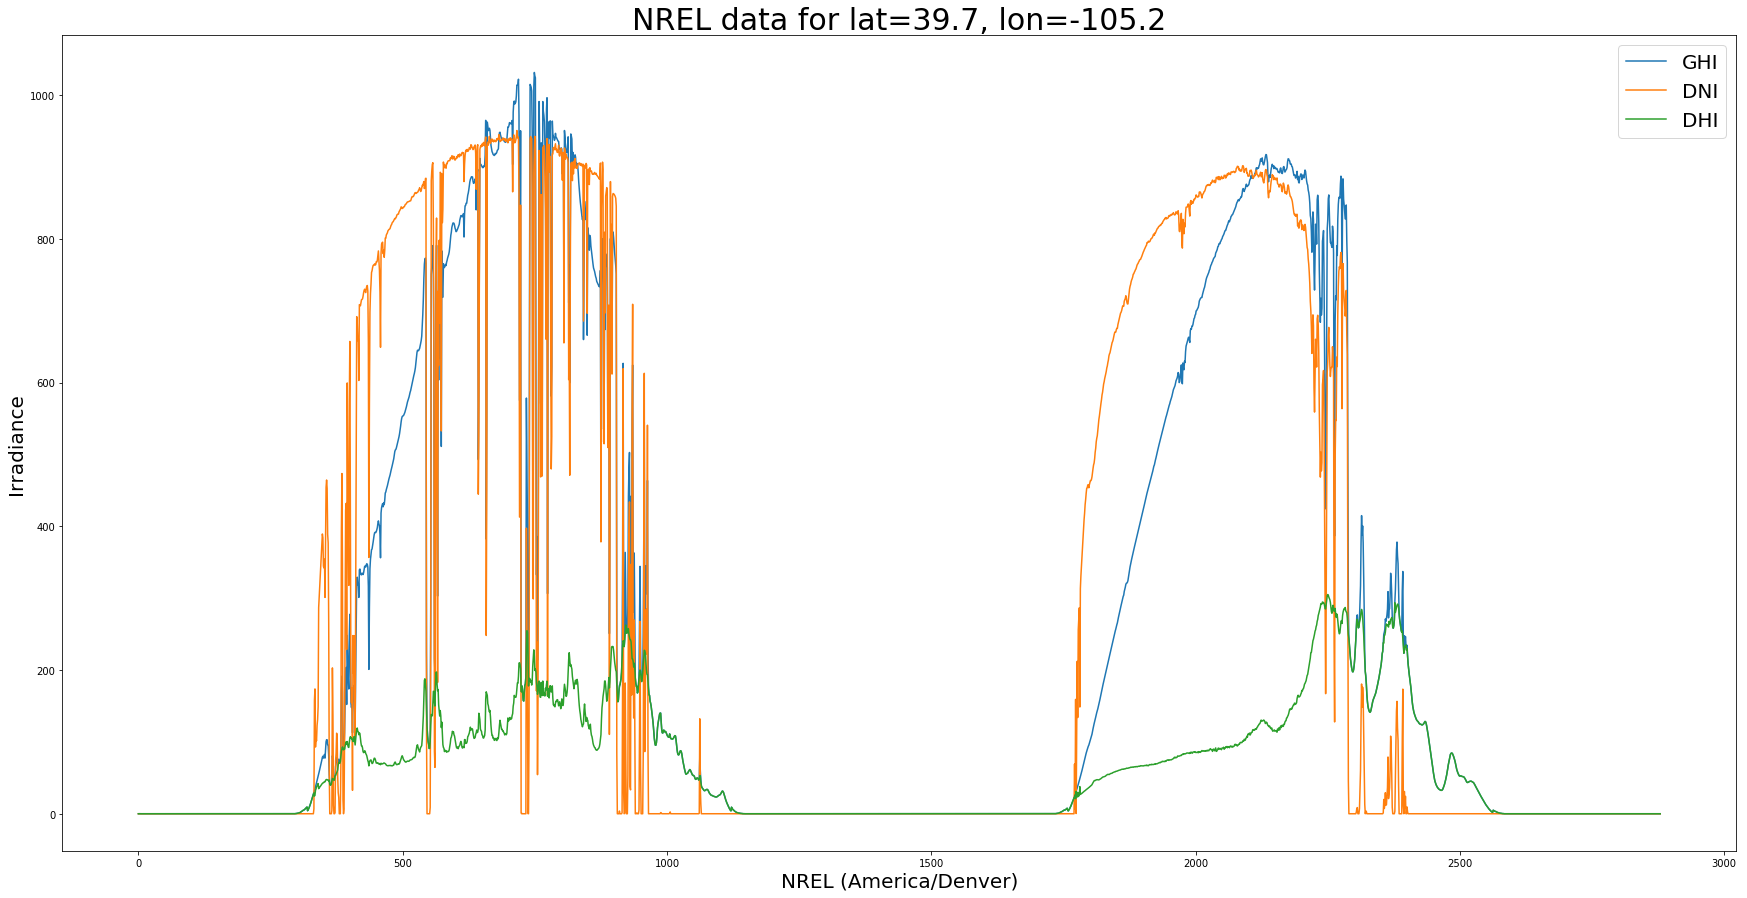

In [19]:
# Plot cloud cover percentages
irrad_var = ['GHI', 'DNI','DHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

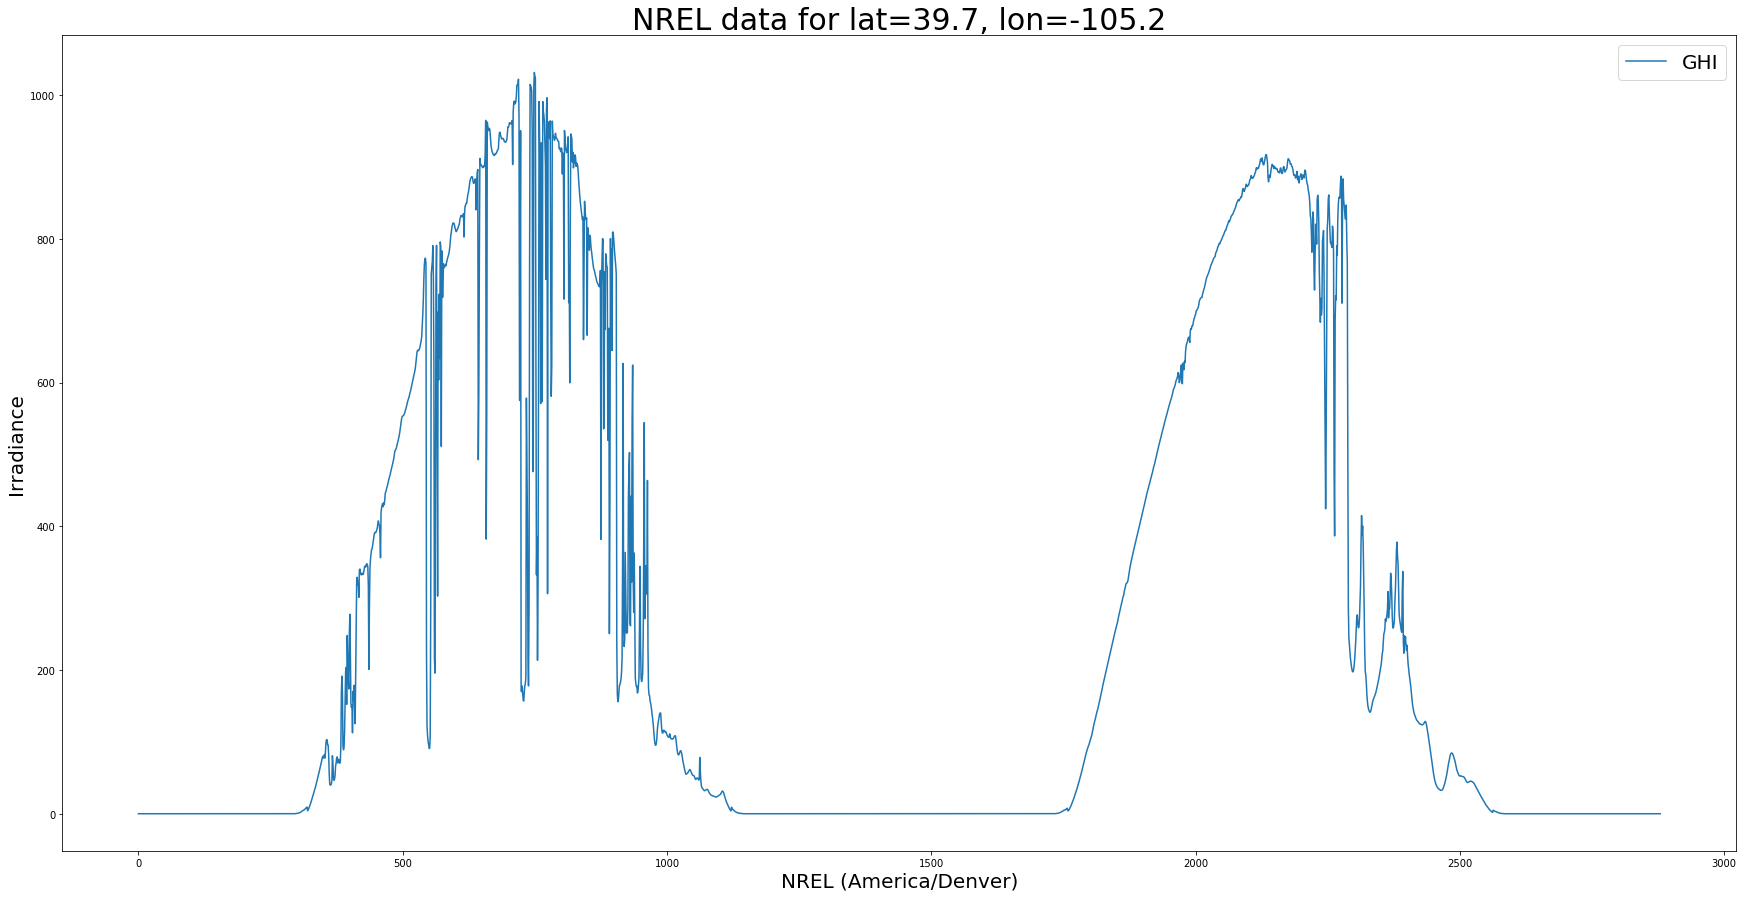

In [20]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

In [33]:
nrel_df_slice = nrel_df.iloc[::45]

In [34]:
nrel_df_slice

,DATE,MST,Time,Hours,GHI,DHI,DNI
0,4/20/2020,2020-05-01 00:00:00,00:00,0.00,0.000000,0.000000,0.0000
45,4/20/2020,2020-05-01 00:45:00,00:45,0.75,0.000000,0.000000,0.0000
90,4/20/2020,2020-05-01 01:30:00,01:30,1.50,0.000000,0.000000,0.0000
135,4/20/2020,2020-05-01 02:15:00,02:15,2.25,0.000000,0.000000,0.0000
180,4/20/2020,2020-05-01 03:00:00,03:00,3.00,0.037063,0.037063,0.0000
225,4/20/2020,2020-05-01 03:45:00,03:45,3.75,0.000000,0.000000,0.0000
270,4/20/2020,2020-05-01 04:30:00,04:30,4.50,0.037063,0.037063,0.0000
315,4/20/2020,2020-05-01 05:15:00,05:15,5.25,6.479410,6.479410,0.0000
360,4/20/2020,2020-05-01 06:00:00,06:00,6.00,80.556200,45.542900,264.8760
405,4/20/2020,2020-05-01 06:45:00,06:45,6.75,112.653000,103.603000,32.5765


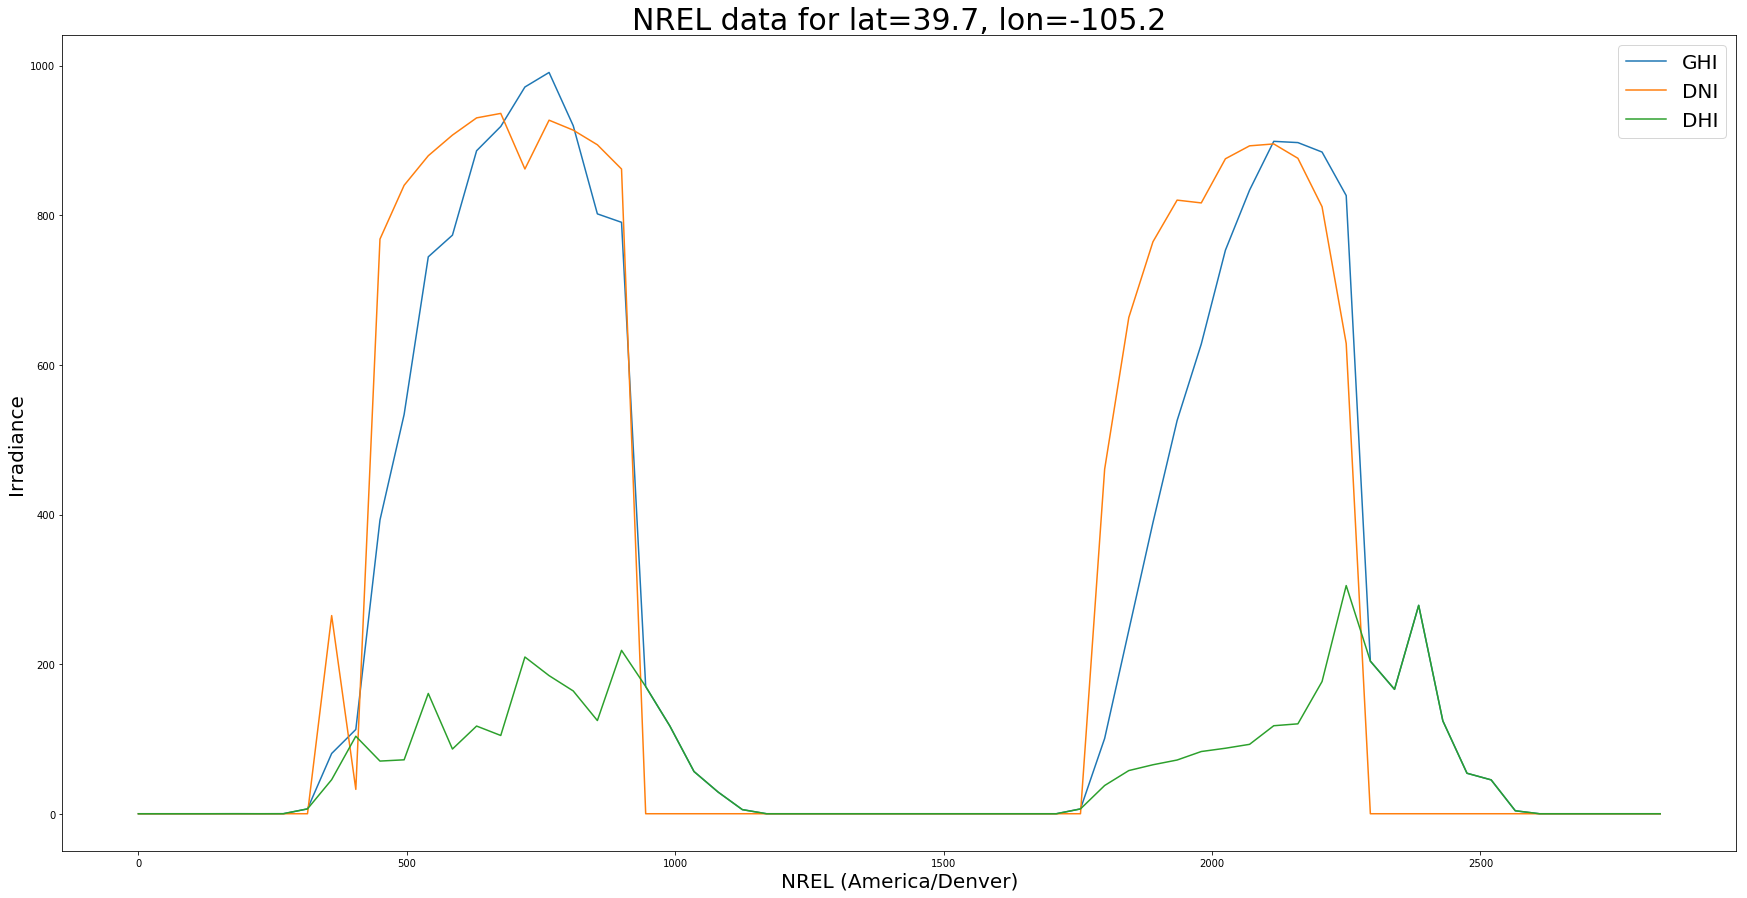

In [35]:
# Plot cloud cover percentages
irrad_var = ['GHI', 'DNI','DHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

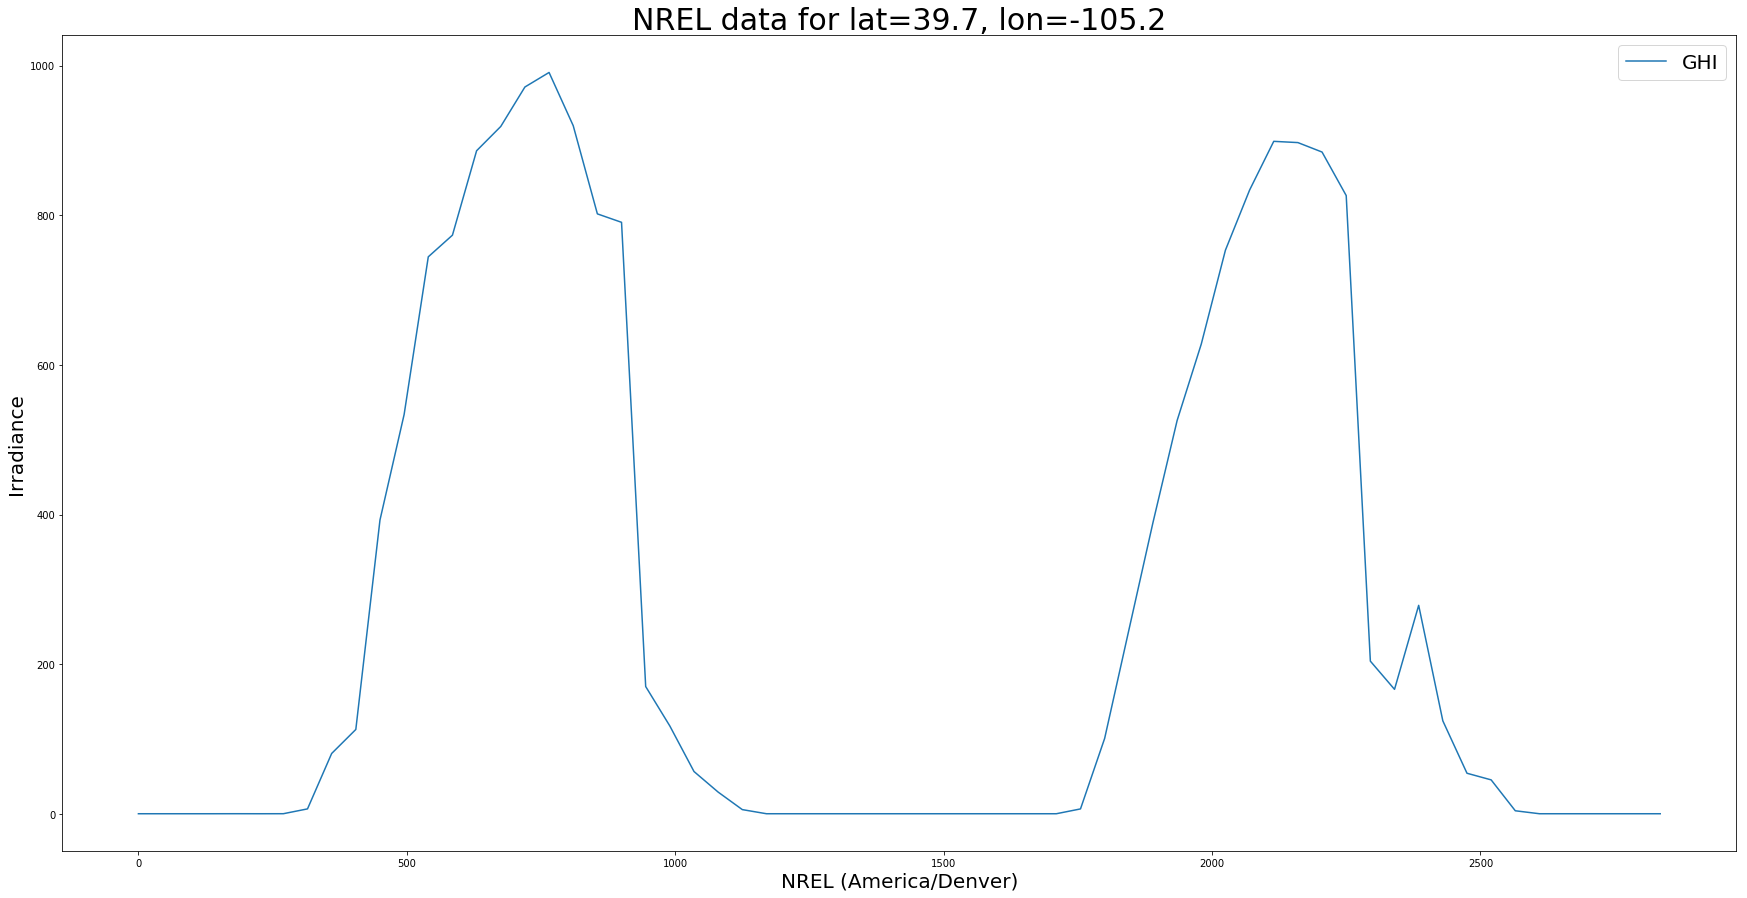

In [36]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

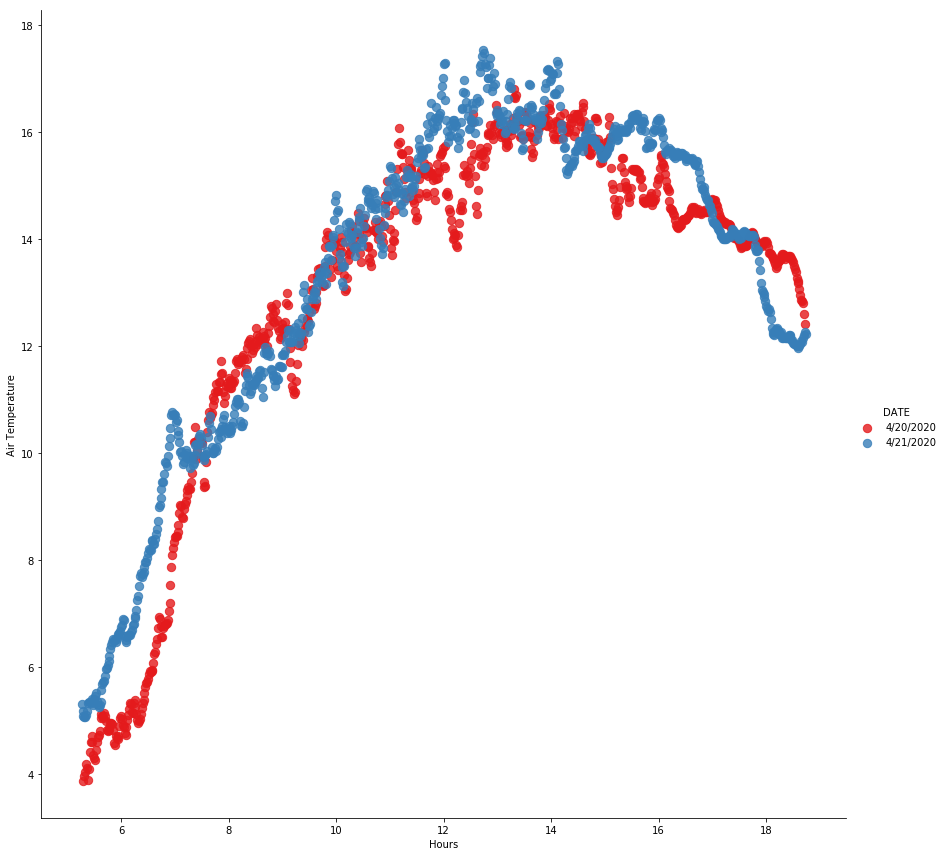

In [94]:
# Plot two parameters (Air Temp & Time)
sns.lmplot('Hours','Air Temperature', data=nrel_df, hue='DATE',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70}, height=12);

In [ ]:
# Plot two parameters (GHI & Time)
sns.lmplot('Hours',y = [['GHI'], ['DHI'], ['DNI']], data=nrel_df, hue='DATE',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70}, height=12);

In [14]:
nrel_df.to_csv('NREL 20 &21.csv', encoding='utf-8')